# Regression in Spark

## Regression Analysis

![Regression](images/regression.png "Regression")

### Regression in Spark

**Techniques**
- Linear Regression (assumes a linear dependency between the variables)
- Generalized Linear Regression (extends the linear model to allow the response variable to have an error distribution other than a normal distribution. It supports various families like Gaussian, Binomial, Poisson, and Gamma)
- Isotonic Regression (When the predicted variable does not oscilate with respect to the input variable)
- Tree-based Regression (Decision Tree, Random Forest, Gradient Boosted Trees)

All of the above mentioned methods use patterns to predict the value of the **label**


### Formatting data for *MLLib*

The main 'quirk' of *MLLib* is that we need to pack data into a format with 1 or 2 columns:
- **Features** (for Unsupervised Learning)
- **Features**, **Label** (for Supervised Learning)

This requires a little more data processing. 
You can always check the documentation at https://spark.apache.org/mllib/ 

In [1]:
from pyspark.sql import SparkSession
spark =  SparkSession.builder.appName('LinReg').getOrCreate()
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType
columns = []
columns.append(StructField('Index', StringType(), True))
columns.append(StructField('Date', TimestampType(), True))
columns.append(StructField('Open', DoubleType(), True))
columns.append(StructField('High', DoubleType(), True))
columns.append(StructField('Low', DoubleType(), True))
columns.append(StructField('Adj Close', DoubleType(), True))
columns.append(StructField('Close', DoubleType(), True))
columns.append(StructField('Volume', DoubleType(), True))
columns.append(StructField('CloseUSD', DoubleType(), True))
schema = StructType(fields=columns)

df = spark.read.csv("stock_data/indexProcessed.csv", header=True, schema=schema)
df = df.na.drop()

In [2]:
df.orderBy(df['Date'].desc()).show()

+---------+-------------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+
|    Index|               Date|       Open|       High|        Low|  Adj Close|      Close|     Volume|          CloseUSD|
+---------+-------------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+
|     N225|2021-06-03 00:00:00|28890.39063|29157.16016|28879.15039|29058.10938|29058.10938|        0.0|       290.5810938|
|     N225|2021-06-02 00:00:00|28730.81055|29003.55078|28565.83008|28946.14063|28946.14063|      7.1E7|       289.4614063|
|     N100|2021-06-02 00:00:00| 1258.48999|1263.709961| 1258.23999|1263.619995|1263.619995|  1.48465E8|      1541.6163939|
|399001.SZ|2021-06-02 00:00:00|15044.94043|15051.20996|14793.74023|14857.91016|14857.91016|  1470800.0|      2377.2656256|
|     N225|2021-06-01 00:00:00|28998.65039| 29075.4707|   28611.25|28814.33984|28814.33984|     4.74E7|       288.1433984|
|     N100|2021-

In [3]:
df = df.withColumn('rate', df.Close/df.CloseUSD)
df.show(5)

+-----+-------------------+-----------+-----------+-----------+-----------+-----------+------+------------------+------------------+
|Index|               Date|       Open|       High|        Low|  Adj Close|      Close|Volume|          CloseUSD|              rate|
+-----+-------------------+-----------+-----------+-----------+-----------+-----------+------+------------------+------------------+
|  HSI|1986-12-31 00:00:00|2568.300049|2568.300049|2568.300049|2568.300049|2568.300049|   0.0|      333.87900637| 7.692307692307692|
|  HSI|1987-01-02 00:00:00|2540.100098|2540.100098|2540.100098|2540.100098|2540.100098|   0.0|      330.21301274| 7.692307692307692|
|  HSI|1987-01-05 00:00:00|2552.399902|2552.399902|2552.399902|2552.399902|2552.399902|   0.0|      331.81198726|7.6923076923076925|
|  HSI|1987-01-06 00:00:00|2583.899902|2583.899902|2583.899902|2583.899902|2583.899902|   0.0|335.90698726000005| 7.692307692307692|
|  HSI|1987-01-07 00:00:00|2607.100098|2607.100098|2607.100098|2607.1

In [4]:
df = df.select(['Index', 'Date', (df.Open / df.rate).alias('OpenUSD'), (df.High / df.rate).alias('HighUSD'), (df.Low / df.rate).alias('LowUSD'), df.CloseUSD, df.Volume])
df.show(5)

+-----+-------------------+------------------+------------------+------------------+------------------+------+
|Index|               Date|           OpenUSD|           HighUSD|            LowUSD|          CloseUSD|Volume|
+-----+-------------------+------------------+------------------+------------------+------------------+------+
|  HSI|1986-12-31 00:00:00|      333.87900637|      333.87900637|      333.87900637|      333.87900637|   0.0|
|  HSI|1987-01-02 00:00:00|      330.21301274|      330.21301274|      330.21301274|      330.21301274|   0.0|
|  HSI|1987-01-05 00:00:00|      331.81198726|      331.81198726|      331.81198726|      331.81198726|   0.0|
|  HSI|1987-01-06 00:00:00|335.90698726000005|335.90698726000005|335.90698726000005|335.90698726000005|   0.0|
|  HSI|1987-01-07 00:00:00|      338.92301274|      338.92301274|      338.92301274|      338.92301274|   0.0|
+-----+-------------------+------------------+------------------+------------------+------------------+------+
o

### VectorAssembler
ML Algorithms from Spark are expecting the features to be packed as a Vector. To assemble multiple columns into a vector of features we can use the Vector Assmebler from Spark. 


In [5]:
from pyspark.ml.feature import VectorAssembler

In [6]:
df.columns

['Index', 'Date', 'OpenUSD', 'HighUSD', 'LowUSD', 'CloseUSD', 'Volume']

The Vector Assembler constructor receives a list of columns and a name for the resulting Vector column. 

In [7]:
assembler = VectorAssembler(inputCols=['OpenUSD', 'HighUSD', 'LowUSD'], outputCol='features')

To make use of the assembler we need to call the transform function on a dataframe. 

In [8]:

output = assembler.transform(df)

The result is a DataFrame that contains the original data and the new Vector column called *features*. 

In [9]:
output.printSchema()

root
 |-- Index: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- OpenUSD: double (nullable = true)
 |-- HighUSD: double (nullable = true)
 |-- LowUSD: double (nullable = true)
 |-- CloseUSD: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- features: vector (nullable = true)



In [10]:
output.show(5, truncate=False)

+-----+-------------------+------------------+------------------+------------------+------------------+------+----------------------------------------------------------+
|Index|Date               |OpenUSD           |HighUSD           |LowUSD            |CloseUSD          |Volume|features                                                  |
+-----+-------------------+------------------+------------------+------------------+------------------+------+----------------------------------------------------------+
|HSI  |1986-12-31 00:00:00|333.87900637      |333.87900637      |333.87900637      |333.87900637      |0.0   |[333.87900637,333.87900637,333.87900637]                  |
|HSI  |1987-01-02 00:00:00|330.21301274      |330.21301274      |330.21301274      |330.21301274      |0.0   |[330.21301274,330.21301274,330.21301274]                  |
|HSI  |1987-01-05 00:00:00|331.81198726      |331.81198726      |331.81198726      |331.81198726      |0.0   |[331.81198726,331.81198726,331.81198726]

In [11]:
final_data = output.select(['Index', 'Date', 'features', 'CloseUSD'])

In [12]:
final_data.orderBy('Close').show()

+-----+-------------------+--------------------+---------+
|Index|               Date|            features| CloseUSD|
+-----+-------------------+--------------------+---------+
| IXIC|1974-10-03 00:00:00|[54.869999,54.869...|54.869999|
| IXIC|1974-10-04 00:00:00| [55.16,55.16,55.16]|    55.16|
| IXIC|1974-10-01 00:00:00| [55.48,55.48,55.48]|    55.48|
| IXIC|1974-09-30 00:00:00|[55.669998,55.669...|55.669998|
| IXIC|1974-10-02 00:00:00|[55.669998,55.669...|55.669998|
| IXIC|1974-10-08 00:00:00|[56.130001,56.130...|56.130001|
| IXIC|1974-10-07 00:00:00| [56.57,56.57,56.57]|    56.57|
| IXIC|1974-09-13 00:00:00| [56.66,56.66,56.66]|    56.66|
| IXIC|1974-09-27 00:00:00|[57.119999,57.119...|57.119999|
| IXIC|1974-09-16 00:00:00|[57.240002,57.240...|57.240002|
| IXIC|1974-10-09 00:00:00| [57.57,57.57,57.57]|    57.57|
| IXIC|1974-09-12 00:00:00|[57.709999,57.709...|57.709999|
| IXIC|1974-09-17 00:00:00|[57.720001,57.720...|57.720001|
| IXIC|1974-12-23 00:00:00|[57.860001,57.860...|57.86000

### Splitting the data
We will split the data into a training set and a validation set. The algorithm will be fitted on the training data and then be tested on data that it has not seen before (test data). 

In [13]:
train_data, test_data = final_data.randomSplit([0.7, 0.3])

## Linear Regression

https://en.wikipedia.org/wiki/Linear_regression

In [14]:
train_data.describe().show()
test_data.describe().show()

+-------+---------+------------------+
|summary|    Index|          CloseUSD|
+-------+---------+------------------+
|  count|    72910|             72910|
|   mean|     NULL|3034.0134964854474|
| stddev|     NULL|3740.8192700200534|
|    min|000001.SS|10.204899900000001|
|    max|     TWII|     18934.3761734|
+-------+---------+------------------+

+-------+---------+-----------------+
|summary|    Index|         CloseUSD|
+-------+---------+-----------------+
|  count|    31314|            31314|
|   mean|     NULL|3076.335752819345|
| stddev|     NULL| 3764.11433858937|
|    min|000001.SS|       10.2677002|
|    max|     TWII|        18860.895|
+-------+---------+-----------------+



In [15]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F
lr = LinearRegression(labelCol='CloseUSD')

In [16]:
lr_model = lr.fit(train_data)

In [17]:
test_results = lr_model.evaluate(test_data)

In [18]:
test_results.residuals.orderBy(F.col('residuals').desc()).show()

+------------------+
|         residuals|
+------------------+
|440.19053138113486|
|434.07453085898123|
| 432.1501732567813|
| 401.3352030082133|
|353.51131439145684|
| 327.6793774582038|
|  277.128064745546|
|267.18816527910985|
|247.74815147757454|
|238.60348600347515|
|215.71000875931622|
|210.76498267640818|
|194.93059431969868|
|183.49019286686053|
|178.85456642767167|
|174.53730601488496|
|174.16690824001125|
|170.28207987246515|
|169.19149271671085|
|167.95569977463947|
+------------------+
only showing top 20 rows



In [19]:
test_results.rootMeanSquaredError

20.23493095439335

In [20]:
test_results.r2

0.9999711004081816

In [21]:
predictions = lr_model.transform(test_data)

In [22]:
predictions.show()

+---------+-------------------+--------------------+------------------+------------------+
|    Index|               Date|            features|          CloseUSD|        prediction|
+---------+-------------------+--------------------+------------------+------------------+
|000001.SS|1997-07-07 00:00:00|[185.873124959999...|       175.4910352|176.42370933572406|
|000001.SS|1997-07-17 00:00:00|[190.12271488,192...|      191.55615232|191.12867140112047|
|000001.SS|1997-07-18 00:00:00|[191.90384768,193...|      193.57712896|192.24474992277516|
|000001.SS|1997-07-22 00:00:00|[190.258886720000...|      193.31968752| 189.4961931404693|
|000001.SS|1997-07-28 00:00:00|[186.850078079999...|      182.68431648| 183.0434996140219|
|000001.SS|1997-07-29 00:00:00|[181.971035200000...|184.51664064000002|184.54513738650624|
|000001.SS|1997-08-12 00:00:00|[188.36175776,189...|       183.4894336|185.10893679510775|
|000001.SS|1997-08-13 00:00:00|[182.27935552,184...|      179.22031248|181.43142914002703|

# Predicting the value for the next day

## Preparing the data
The following cell creates a Window which partitions the data by Index and orders it by date. Next, we will add a new column, *NextDayClose*; This column is constructed using the **lead** function, which will copy the next value from the "CloseUSD" column. 
The *lead* function is applied on the Window we defined, ensuring that the next item will be taken for the same index, ordered by date. 

In [23]:
from pyspark.sql import Window

# Define the window specification
windowSpec = Window.partitionBy("Index").orderBy("Date")

# Add a new column with the next day's close price
final_data = final_data.withColumn("NextDayClose", F.lead("CloseUSD", 1).over(windowSpec))

final_data.show()

+------+-------------------+--------------------+------------------+------------------+
| Index|               Date|            features|          CloseUSD|      NextDayClose|
+------+-------------------+--------------------+------------------+------------------+
|GSPTSE|1979-06-29 00:00:00|[1343.61311309838...|     1343.27201992|     1330.32404067|
|GSPTSE|1979-07-03 00:00:00|[1342.69766049326...|     1330.32404067|     1320.86201992|
|GSPTSE|1979-07-04 00:00:00|[1332.62912678841...|     1320.86201992|     1314.63701992|
|GSPTSE|1979-07-05 00:00:00|[1323.05993064883...|     1314.63701992|1316.8779800799998|
|GSPTSE|1979-07-06 00:00:00|[1317.98394241935...|1316.8779800799998|     1316.62904067|
|GSPTSE|1979-07-09 00:00:00|[1320.23073434835...|     1316.62904067|     1311.56595933|
|GSPTSE|1979-07-10 00:00:00|[1318.81617130068...|     1311.56595933|     1297.45595933|
|GSPTSE|1979-07-11 00:00:00|[1312.07593809542...|     1297.45595933|     1272.97095933|
|GSPTSE|1979-07-12 00:00:00|[129

## Training on history, predicting recent values
In the previous section we used random split to create a training and a testing dataset. Another approach is to split based on time. In the next scenario we will use the first 98% of the data for training and the rest of 2% for testing. 

In [24]:
df = final_data.orderBy("Date").na.drop()

# Step 2: Add a row number column
window = Window.orderBy("Date")
df_with_row_number = df.withColumn("row_number", F.row_number().over(window))

total_rows = df_with_row_number.count()
split_point = int(total_rows * 0.98)

train_df = df_with_row_number.filter(df_with_row_number.row_number <= split_point).drop("row_number")
test_df = df_with_row_number.filter(df_with_row_number.row_number > split_point).drop("row_number")


In [25]:
lr = LinearRegression(labelCol='NextDayClose')
lr_model = lr.fit(train_df)
test_results = lr_model.evaluate(test_df)
print(test_results.rootMeanSquaredError, test_results.r2)
predictions = lr_model.transform(test_df)

95.43966682708565 0.999779391740873


In [26]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="NextDayClose", predictionCol="prediction")

glr = GeneralizedLinearRegression(family="gaussian", link="identity", labelCol='NextDayClose')
model = glr.fit(train_df)
predictions=model.transform(test_df)

evaluator.setMetricName("rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print("R^2 on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 95.43966682708565
R^2 on test data = 0.999779391740873


In [27]:
from pyspark.ml.regression import IsotonicRegression

ir = IsotonicRegression(labelCol='NextDayClose')
model = ir.fit(train_df)

predictions=model.transform(test_df)

evaluator.setMetricName("rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print("R^2 on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 307.86425119041985
R^2 on test data = 0.9977044726973212


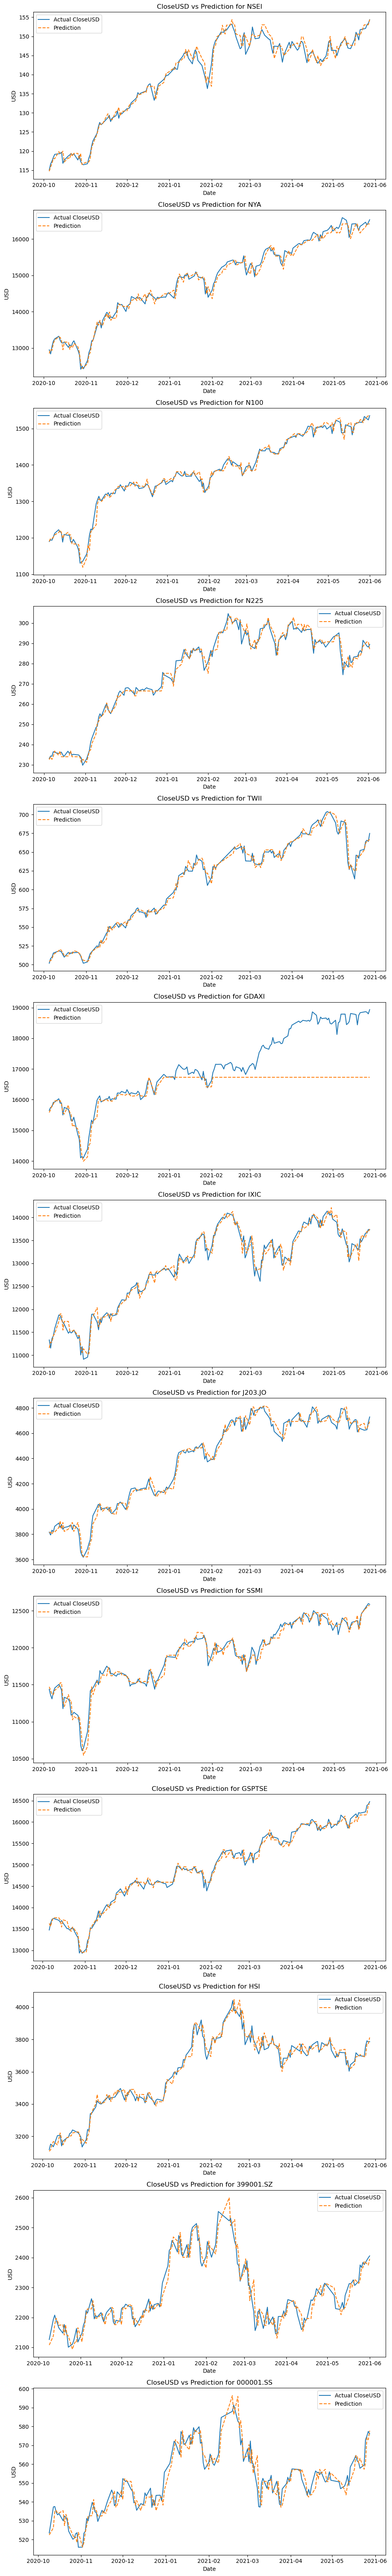

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
pdf = predictions.toPandas()

# Get unique indices
indices = pdf['Index'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(indices), ncols=1, figsize=(10, 5 * len(indices)))

# If there is only one index, axes will not be an array, wrap it in a list for uniform handling
if len(indices) == 1:
    axes = [axes]

# Plot data for each index
for ax, index in zip(axes, indices):
    subset = pdf[pdf['Index'] == index]
    ax.plot(subset['Date'], subset['CloseUSD'], label='Actual CloseUSD')
    ax.plot(subset['Date'], subset['prediction'], label='Prediction', linestyle='--')
    ax.set_title(f'CloseUSD vs Prediction for {index}')
    ax.set_xlabel('Date')
    ax.set_ylabel('USD')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()
